**3rd model**

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/u

Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 216      |
|    time_elapsed    | 43       |
|    total_timesteps | 9496     |
| train/             |          |
|    actor_loss      | 18.4     |
|    critic_loss     | 40.7     |
|    learning_rate   | 0.0005   |
|    n_updates       | 7122     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 187      |
|    time_elapsed    | 101      |
|    total_timesteps | 18992    |
| train/             |          |
|    actor_loss      | 32.7     |
|    critic_loss     | 48.8     |
|    learning_rate   | 0.0005   |
|    n_updates       | 16618    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 180      |
|    time_elapsed    | 158    

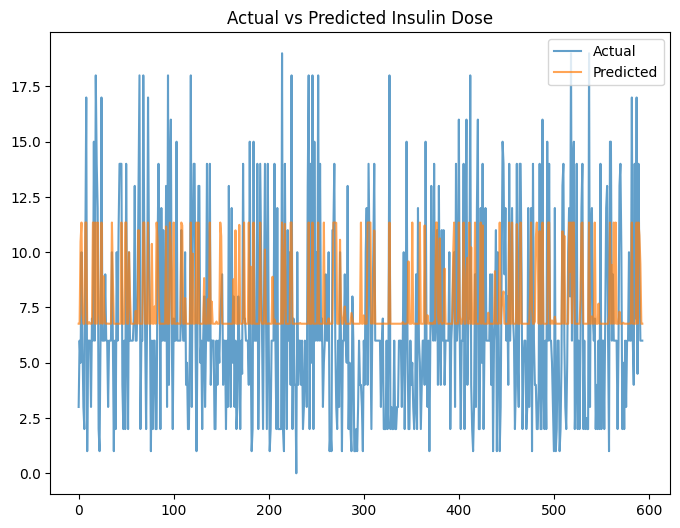

In [10]:
# Install missing libraries
#!pip install stable-baselines3[extra] gymnasium numpy pandas scikit-learn matplotlib --quiet

import numpy as np
import pandas as pd
import gymnasium as gym
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/kaggle/input/pp-diabetes/pp_dataset.csv")  # Adjust if needed

# Rename columns for consistency
df.rename(columns={
    "Pre-breakfast blood glucose measurement": "pre_breakfast_glucose",
    "Regular_insulin_Pre-breakfast_blood_glucose": "regular_insulin_pre_breakfast",
    "NPH insulin dose": "NPH_insulin_dose",
    "Pre-supper blood glucose measurement": "pre_supper_glucose",
    "Regular insulin dose": "regular_insulin_dose"
}, inplace=True)

# Data Preprocessing
# Remove outliers (winsorize to 5th and 95th percentiles)
df['pre_breakfast_glucose'] = df['pre_breakfast_glucose'].clip(df['pre_breakfast_glucose'].quantile(0.05), df['pre_breakfast_glucose'].quantile(0.95))
df['NPH_insulin_dose'] = df['NPH_insulin_dose'].clip(df['NPH_insulin_dose'].quantile(0.05), df['NPH_insulin_dose'].quantile(0.95))

# Add interaction terms
df['glucose_insulin_interaction'] = df['pre_breakfast_glucose'] * df['NPH_insulin_dose']

# Additional Feature Engineering
df['hour'] = pd.to_datetime(df.index, unit='D').hour
df['weekday'] = pd.to_datetime(df.index, unit='D').weekday
df['glucose_diff'] = df['pre_breakfast_glucose'] - df['pre_supper_glucose']
df['glucose_insulin_ratio'] = df['pre_breakfast_glucose'] / (df['NPH_insulin_dose'] + 1e-5)
df['insulin_diff'] = df['NPH_insulin_dose'].diff().fillna(0)

df.dropna(inplace=True)

# Feature Selection
features = [
    "pre_breakfast_glucose", "NPH_insulin_dose", "pre_supper_glucose", 
    "hour", "weekday", "glucose_diff", "glucose_insulin_ratio", 
    "insulin_diff", "glucose_insulin_interaction"
]
target = "regular_insulin_dose"

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Custom Gym Environment
class InsulinEnv(gym.Env):
    def __init__(self, X, y):
        super(InsulinEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.index = 0
        return np.array(self.X[self.index]), {}

    def step(self, action):
        actual_dose = self.y[self.index]
        predicted_dose = np.clip(action[0], 0, 1)
        error = abs(actual_dose - predicted_dose)

        # Enhanced Reward Function
        if error < 0.1:
            reward = 1 - (error ** 2)  # Small positive reward for small error
        elif error < 0.5:
            reward = -error  # Mild penalty for moderate error
        else:
            reward = -2 * (error ** 2)  # Larger penalty for high error

        self.index += 1
        done = self.index >= len(self.X)
        next_state = np.array(self.X[self.index]) if not done else np.zeros(self.observation_space.shape, dtype=np.float32)

        return next_state, reward, done, False, {}

# Convert dataset to NumPy for Gym Environment
X_train_np = np.array(X_train_scaled, dtype=np.float32)
y_train_np = np.array(y_train_scaled, dtype=np.float32)

# Create environment
env = DummyVecEnv([lambda: InsulinEnv(X_train_np, y_train_np)])

# Updated Policy Network
policy_kwargs = dict(net_arch=[512, 256, 128])

# Train TD3 Model with Updated Hyperparameters
model = TD3(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=5e-4,         # Increased learning rate
    gamma=0.95,                 # Short-term focus
    batch_size=128,             # Smaller batches for more frequent updates
    buffer_size=1000000,        # Larger buffer size for better learning
    policy_kwargs=policy_kwargs
)

# Early Stopping
best_reward = -np.inf
patience = 5
patience_counter = 0

for _ in range(10):
    model.learn(total_timesteps=200000)
    mean_reward = np.mean([model.predict(X_test_scaled[i])[0] for i in range(len(X_test_scaled))])
    
    if mean_reward > best_reward:
        best_reward = mean_reward
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Evaluation Function
def evaluate_model(model, X_test, y_test):
    predictions = np.array([model.predict(X_test[i])[0] for i in range(len(X_test))])
    predictions = y_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    return mse, mae, r2, predictions

# Evaluate Model
mse, mae, r2, predictions = evaluate_model(model, X_test_scaled, y_test_scaled)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# Plot Predictions vs Actual Values
plt.figure(figsize=(8, 6))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title("Actual vs Predicted Insulin Dose")
plt.legend()
plt.show()


**4thh model**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a futur

Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 208      |
|    time_elapsed    | 45       |
|    total_timesteps | 9496     |
| train/             |          |
|    actor_loss      | 22       |
|    critic_loss     | 45.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 7122     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 183      |
|    time_elapsed    | 103      |
|    total_timesteps | 18992    |
| train/             |          |
|    actor_loss      | 50.1     |
|    critic_loss     | 61.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 16618    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 176      |
|    time_elapsed    | 161    

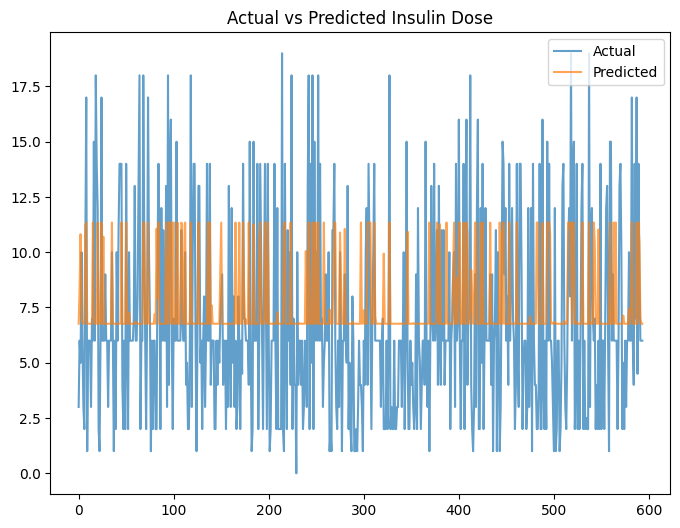

In [2]:
import numpy as np
import pandas as pd
import gymnasium as gym
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/kaggle/input/pp-diabetes/pp_dataset.csv")  # Adjust path if needed

# Rename columns for consistency
df.rename(columns={
    "Pre-breakfast blood glucose measurement": "pre_breakfast_glucose",
    "Regular_insulin_Pre-breakfast_blood_glucose": "regular_insulin_pre_breakfast",
    "NPH insulin dose": "NPH_insulin_dose",
    "Pre-supper blood glucose measurement": "pre_supper_glucose",
    "Regular insulin dose": "regular_insulin_dose"
}, inplace=True)

# Data Preprocessing
# Remove outliers (winsorize to 5th and 95th percentiles)
df['pre_breakfast_glucose'] = df['pre_breakfast_glucose'].clip(df['pre_breakfast_glucose'].quantile(0.05), df['pre_breakfast_glucose'].quantile(0.95))
df['NPH_insulin_dose'] = df['NPH_insulin_dose'].clip(df['NPH_insulin_dose'].quantile(0.05), df['NPH_insulin_dose'].quantile(0.95))

# Feature Engineering
df['glucose_insulin_interaction'] = df['pre_breakfast_glucose'] * df['NPH_insulin_dose']
df['hour'] = pd.to_datetime(df.index, unit='D').hour
df['weekday'] = pd.to_datetime(df.index, unit='D').weekday
df['glucose_diff'] = df['pre_breakfast_glucose'] - df['pre_supper_glucose']
df['glucose_insulin_ratio'] = df['pre_breakfast_glucose'] / (df['NPH_insulin_dose'] + 1e-5)
df['insulin_diff'] = df['NPH_insulin_dose'].diff().fillna(0)

df.dropna(inplace=True)

# Feature Selection
features = [
    "pre_breakfast_glucose", "NPH_insulin_dose", "pre_supper_glucose", 
    "hour", "weekday", "glucose_diff", "glucose_insulin_ratio", 
    "insulin_diff", "glucose_insulin_interaction"
]
target = "regular_insulin_dose"

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Custom Gym Environment
class InsulinEnv(gym.Env):
    def __init__(self, X, y):
        super(InsulinEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.index = 0
        return np.array(self.X[self.index]), {}

    def step(self, action):
        actual_dose = self.y[self.index]
        predicted_dose = np.clip(action[0], 0, 1)
        error = abs(actual_dose - predicted_dose)
        
        reward = 1 - (error ** 2) if error < 0.1 else (-error if error < 0.5 else -2 * (error ** 2))
        
        self.index += 1
        done = self.index >= len(self.X)
        next_state = np.array(self.X[self.index]) if not done else np.zeros(self.observation_space.shape, dtype=np.float32)
        
        return next_state, reward, done, False, {}

# Convert dataset to NumPy for Gym Environment
X_train_np = np.array(X_train_scaled, dtype=np.float32)
y_train_np = np.array(y_train_scaled, dtype=np.float32)

# Create environment
env = DummyVecEnv([lambda: InsulinEnv(X_train_np, y_train_np)])

# Updated Policy Network
policy_kwargs = dict(net_arch=[512, 256, 128])

# Train TD3 Model with Updated Hyperparameters
model = TD3(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=1e-3,  # Increased learning rate for faster convergence
    gamma=0.97,  # Slightly longer-term focus
    batch_size=256,  # Larger batch for stable updates
    buffer_size=2000000,  # Larger buffer for better experience replay
    policy_kwargs=policy_kwargs
)

# Training with Early Stopping
best_reward = -np.inf
patience = 7  # Increased patience
patience_counter = 0

for _ in range(12):  # More iterations
    model.learn(total_timesteps=250000)
    mean_reward = np.mean([model.predict(X_test_scaled[i])[0] for i in range(len(X_test_scaled))])
    
    if mean_reward > best_reward:
        best_reward = mean_reward
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Evaluation Function
def evaluate_model(model, X_test, y_test):
    predictions = np.array([model.predict(X_test[i])[0] for i in range(len(X_test))])
    predictions = y_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    return mse, mae, r2, predictions

# Evaluate Model
mse, mae, r2, predictions = evaluate_model(model, X_test_scaled, y_test_scaled)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# Plot Predictions vs Actual Values
plt.figure(figsize=(8, 6))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title("Actual vs Predicted Insulin Dose")
plt.legend()
plt.show()


**5th**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a futur

Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 206      |
|    time_elapsed    | 45       |
|    total_timesteps | 9496     |
| train/             |          |
|    actor_loss      | 4.58     |
|    critic_loss     | 8.26     |
|    learning_rate   | 0.0003   |
|    n_updates       | 7122     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 180      |
|    time_elapsed    | 104      |
|    total_timesteps | 18992    |
| train/             |          |
|    actor_loss      | 5.27     |
|    critic_loss     | 7.34     |
|    learning_rate   | 0.0003   |
|    n_updates       | 16618    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 173      |
|    time_elapsed    | 164    

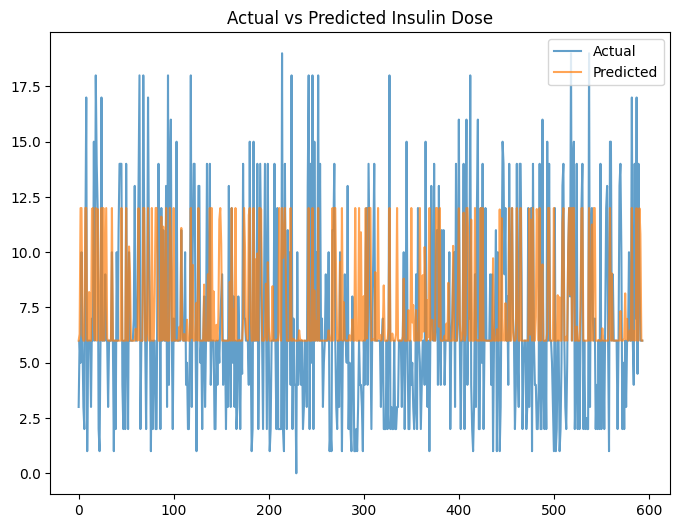

In [6]:
# Install missing libraries
#!pip install stable-baselines3[extra] gymnasium numpy pandas scikit-learn matplotlib --quiet

import numpy as np
import pandas as pd
import gymnasium as gym
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/kaggle/input/pp-diabetes/pp_dataset.csv")  # Adjust if needed

# Rename columns for consistency
df.rename(columns={
    "Pre-breakfast blood glucose measurement": "pre_breakfast_glucose",
    "Regular_insulin_Pre-breakfast_blood_glucose": "regular_insulin_pre_breakfast",
    "NPH insulin dose": "NPH_insulin_dose",
    "Pre-supper blood glucose measurement": "pre_supper_glucose",
    "Regular insulin dose": "regular_insulin_dose"
}, inplace=True)

# Data Preprocessing
# Remove outliers (winsorize to 5th and 95th percentiles)
df['pre_breakfast_glucose'] = df['pre_breakfast_glucose'].clip(df['pre_breakfast_glucose'].quantile(0.05), df['pre_breakfast_glucose'].quantile(0.95))
df['NPH_insulin_dose'] = df['NPH_insulin_dose'].clip(df['NPH_insulin_dose'].quantile(0.05), df['NPH_insulin_dose'].quantile(0.95))

# Add interaction terms
df['glucose_insulin_interaction'] = df['pre_breakfast_glucose'] * df['NPH_insulin_dose']

# Additional Feature Engineering
df['hour'] = pd.to_datetime(df.index, unit='D').hour
df['weekday'] = pd.to_datetime(df.index, unit='D').weekday
df['glucose_diff'] = df['pre_breakfast_glucose'] - df['pre_supper_glucose']
df['glucose_insulin_ratio'] = df['pre_breakfast_glucose'] / (df['NPH_insulin_dose'] + 1e-5)
df['insulin_diff'] = df['NPH_insulin_dose'].diff().fillna(0)

df.dropna(inplace=True)

# Feature Selection
features = [
    "pre_breakfast_glucose", "NPH_insulin_dose", "pre_supper_glucose", 
    "hour", "weekday", "glucose_diff", "glucose_insulin_ratio", 
    "insulin_diff", "glucose_insulin_interaction"
]
target = "regular_insulin_dose"

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Custom Gym Environment
class InsulinEnv(gym.Env):
    def __init__(self, X, y):
        super(InsulinEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.index = 0
        return np.array(self.X[self.index]), {}

    def step(self, action):
        actual_dose = self.y[self.index]
        predicted_dose = np.clip(action[0], 0, 1)
        error = abs(actual_dose - predicted_dose)

        # Enhanced Reward Function
        reward = 1 - (error ** 2) if error < 0.1 else -1.5 * (error ** 2)
        
        self.index += 1
        done = self.index >= len(self.X)
        next_state = np.array(self.X[self.index]) if not done else np.zeros(self.observation_space.shape, dtype=np.float32)

        return next_state, reward, done, False, {}

# Convert dataset to NumPy for Gym Environment
X_train_np = np.array(X_train_scaled, dtype=np.float32)
y_train_np = np.array(y_train_scaled, dtype=np.float32)

# Create environment
env = DummyVecEnv([lambda: InsulinEnv(X_train_np, y_train_np)])

# Updated Policy Network
policy_kwargs = dict(net_arch=[1024, 512, 256])

# Add Action Noise for Exploration
action_noise = NormalActionNoise(mean=np.zeros(1), sigma=0.2 * np.ones(1))

# Train TD3 Model with Updated Hyperparameters
model = TD3(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,        # Adjusted learning rate
    gamma=0.90,                # Short-term focus
    batch_size=256,            # Larger batch size
    buffer_size=1000000,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise
)

# Train Model with Learning Rate Decay
for i in range(10):
    model.learn(total_timesteps=200000)
    model.learning_rate *= 0.9  # Apply decay

# Evaluation Function
def evaluate_model(model, X_test, y_test):
    predictions = np.array([model.predict(X_test[i])[0] for i in range(len(X_test))])
    predictions = y_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    return mse, mae, r2, predictions

# Evaluate Model
mse, mae, r2, predictions = evaluate_model(model, X_test_scaled, y_test_scaled)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# Plot Predictions vs Actual Values
plt.figure(figsize=(8, 6))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title("Actual vs Predicted Insulin Dose")
plt.legend()
plt.show()


**6th**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, con

Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 124      |
|    time_elapsed    | 76       |
|    total_timesteps | 9496     |
| train/             |          |
|    actor_loss      | 11.3     |
|    critic_loss     | 20.4     |
|    learning_rate   | 0.0005   |
|    n_updates       | 7122     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 108      |
|    time_elapsed    | 175      |
|    total_timesteps | 18992    |
| train/             |          |
|    actor_loss      | 19.6     |
|    critic_loss     | 18.6     |
|    learning_rate   | 0.0005   |
|    n_updates       | 16618    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 104      |
|    time_elapsed    | 272    

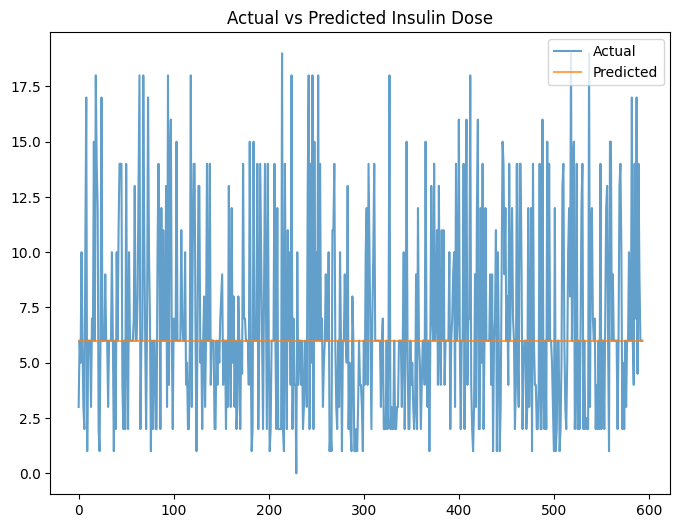

In [2]:
# Install missing libraries
#!pip install stable-baselines3[extra] gymnasium numpy pandas scikit-learn matplotlib --quiet

import numpy as np
import pandas as pd
import gymnasium as gym
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/kaggle/input/pp-diabetes/pp_dataset.csv")  # Adjust if needed

# Rename columns for consistency
df.rename(columns={
    "Pre-breakfast blood glucose measurement": "pre_breakfast_glucose",
    "Regular_insulin_Pre-breakfast_blood_glucose": "regular_insulin_pre_breakfast",
    "NPH insulin dose": "NPH_insulin_dose",
    "Pre-supper blood glucose measurement": "pre_supper_glucose",
    "Regular insulin dose": "regular_insulin_dose"
}, inplace=True)

# Data Preprocessing
df['pre_breakfast_glucose'] = df['pre_breakfast_glucose'].clip(df['pre_breakfast_glucose'].quantile(0.05), df['pre_breakfast_glucose'].quantile(0.95))
df['NPH_insulin_dose'] = df['NPH_insulin_dose'].clip(df['NPH_insulin_dose'].quantile(0.05), df['NPH_insulin_dose'].quantile(0.95))

# Feature Engineering
df['glucose_insulin_interaction'] = df['pre_breakfast_glucose'] * df['NPH_insulin_dose']
df['glucose_diff'] = df['pre_breakfast_glucose'] - df['pre_supper_glucose']
df['glucose_insulin_ratio'] = df['pre_breakfast_glucose'] / (df['NPH_insulin_dose'] + 1e-5)
df['insulin_diff'] = df['NPH_insulin_dose'].diff().fillna(0)

df.dropna(inplace=True)

# Feature Selection
features = [
    "pre_breakfast_glucose", "NPH_insulin_dose", "pre_supper_glucose", 
    "glucose_diff", "glucose_insulin_ratio", "insulin_diff", "glucose_insulin_interaction"
]
target = "regular_insulin_dose"

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Custom Gym Environment
class InsulinEnv(gym.Env):
    def __init__(self, X, y):
        super(InsulinEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.index = 0
        return np.array(self.X[self.index]), {}

    def step(self, action):
        actual_dose = self.y[self.index]
        predicted_dose = np.clip(action[0], 0, 1)
        error = abs(actual_dose - predicted_dose)

        # Optimized Reward Function
        reward = np.exp(-5 * error) if error < 0.2 else -2 * (error ** 2)

        self.index += 1
        done = self.index >= len(self.X)
        next_state = np.array(self.X[self.index]) if not done else np.zeros(self.observation_space.shape, dtype=np.float32)

        return next_state, reward, done, False, {}

# Convert dataset to NumPy for Gym Environment
X_train_np = np.array(X_train_scaled, dtype=np.float32)
y_train_np = np.array(y_train_scaled, dtype=np.float32)

# Create environment
env = DummyVecEnv([lambda: InsulinEnv(X_train_np, y_train_np)])

# Optimized Policy Network
policy_kwargs = dict(net_arch=[2048, 1024, 512])

# Action Noise for Exploration
action_noise = NormalActionNoise(mean=np.zeros(1), sigma=0.15 * np.ones(1))

# Train TD3 Model with Optimized Parameters
model = TD3(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=5e-4,        # Higher initial learning rate
    gamma=0.95,                # Balanced focus
    batch_size=512,            # Larger batch size
    buffer_size=1000000,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise
)

# Train Model with Learning Rate Decay
for i in range(10):
    model.learn(total_timesteps=250000)
    model.learning_rate *= 0.9  # Apply decay

# Evaluation Function
def evaluate_model(model, X_test, y_test):
    predictions = np.array([model.predict(X_test[i])[0] for i in range(len(X_test))])
    predictions = y_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    return mse, mae, r2, predictions

# Evaluate Model
mse, mae, r2, predictions = evaluate_model(model, X_test_scaled, y_test_scaled)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# Plot Predictions vs Actual Values
plt.figure(figsize=(8, 6))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title("Actual vs Predicted Insulin Dose")
plt.legend()
plt.show()


**7th**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a futur

Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 177      |
|    time_elapsed    | 53       |
|    total_timesteps | 9496     |
| train/             |          |
|    actor_loss      | 9.11     |
|    critic_loss     | 9.53     |
|    learning_rate   | 0.0003   |
|    n_updates       | 7122     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 155      |
|    time_elapsed    | 121      |
|    total_timesteps | 18992    |
| train/             |          |
|    actor_loss      | 18.3     |
|    critic_loss     | 15.8     |
|    learning_rate   | 0.0003   |
|    n_updates       | 16618    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 149      |
|    time_elapsed    | 190    

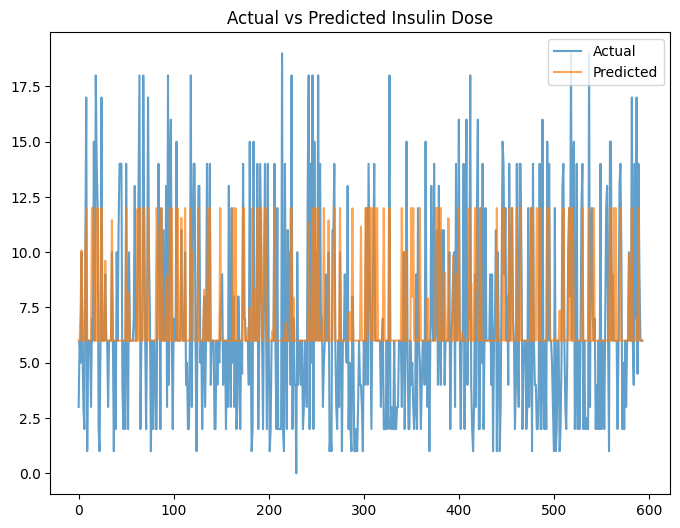

In [5]:
import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load dataset
df = pd.read_csv("/kaggle/input/pp-diabetes/pp_dataset.csv")

df.rename(columns={
    "Pre-breakfast blood glucose measurement": "pre_breakfast_glucose",
    "Regular_insulin_Pre-breakfast_blood_glucose": "regular_insulin_pre_breakfast",
    "NPH insulin dose": "NPH_insulin_dose",
    "Pre-supper blood glucose measurement": "pre_supper_glucose",
    "Regular insulin dose": "regular_insulin_dose"
}, inplace=True)

# Outlier Clipping
df['pre_breakfast_glucose'] = df['pre_breakfast_glucose'].clip(df['pre_breakfast_glucose'].quantile(0.05), df['pre_breakfast_glucose'].quantile(0.95))
df['NPH_insulin_dose'] = df['NPH_insulin_dose'].clip(df['NPH_insulin_dose'].quantile(0.05), df['NPH_insulin_dose'].quantile(0.95))

# Feature Engineering
df['glucose_insulin_interaction'] = df['pre_breakfast_glucose'] * df['NPH_insulin_dose']
df['glucose_diff'] = df['pre_breakfast_glucose'] - df['pre_supper_glucose']
df['glucose_insulin_ratio'] = df['pre_breakfast_glucose'] / (df['NPH_insulin_dose'] + 1e-5)
df['insulin_diff'] = df['NPH_insulin_dose'].diff().fillna(0)
df.dropna(inplace=True)

# Define Features and Target
features = ["pre_breakfast_glucose", "NPH_insulin_dose", "pre_supper_glucose", "glucose_diff", "glucose_insulin_ratio", "insulin_diff", "glucose_insulin_interaction"]
target = "regular_insulin_dose"
X = df[features]
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling Features and Target
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Custom Gym Environment
class InsulinEnv(gym.Env):
    def __init__(self, X, y):
        super(InsulinEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.index = 0
        return np.array(self.X[self.index]), {}

    def step(self, action):
        actual_dose = self.y[self.index]
        predicted_dose = np.clip(action[0], 0, 1)
        error = abs(actual_dose - predicted_dose)
        reward = np.exp(-5 * error) if error < 0.2 else -2 * (error ** 2)
        self.index += 1
        done = self.index >= len(self.X)
        next_state = np.array(self.X[self.index]) if not done else np.zeros(self.observation_space.shape, dtype=np.float32)
        return next_state, reward, done, False, {}

# Create Environment
X_train_np = np.array(X_train_scaled, dtype=np.float32)
y_train_np = np.array(y_train_scaled, dtype=np.float32)
env = DummyVecEnv([lambda: InsulinEnv(X_train_np, y_train_np)])

# Model Configuration
policy_kwargs = dict(net_arch=[1024, 512, 256])
action_noise = NormalActionNoise(mean=np.zeros(1), sigma=0.1 * np.ones(1))

model = TD3(
    "MlpPolicy", env, verbose=1, learning_rate=3e-4, gamma=0.97,
    batch_size=256, buffer_size=500000, policy_kwargs=policy_kwargs, action_noise=action_noise
)

# Training Loop
for i in range(15):
    model.learn(total_timesteps=200000)
    model.learning_rate *= 0.85  # Learning rate decay

# Model Evaluation
def evaluate_model(model, X_test, y_test):
    predictions = np.array([model.predict(X_test[i])[0] for i in range(len(X_test))])
    predictions = y_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, mae, r2, predictions

mse, mae, r2, predictions = evaluate_model(model, X_test_scaled, y_test_scaled)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# Plot Results
plt.figure(figsize=(8, 6))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title("Actual vs Predicted Insulin Dose")
plt.legend()
plt.show()

**8th model**

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: tensorboard 2.17.1
Uninstalling tensorboard-2.17.1:
  Successfully uninstalled tensorboard-2.17.1
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow
ERROR: Could not find a version that satisfies the requirement tensorboard (from versions: none)
ERROR: No matching distribution found for tensorboard
ERROR: Could not find a version that satisfies the requirement tensorflow==2.11.0 (from versions: none)
ERROR: No matching distribution found for tensorflow==2.11.0


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/u

Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 202      |
|    time_elapsed    | 42       |
|    total_timesteps | 8560     |
| train/             |          |
|    actor_loss      | 14.7     |
|    critic_loss     | 46.5     |
|    learning_rate   | 0.00025  |
|    n_updates       | 6420     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 177      |
|    time_elapsed    | 96       |
|    total_timesteps | 17120    |
| train/             |          |
|    actor_loss      | 32.6     |
|    critic_loss     | 52.2     |
|    learning_rate   | 0.00025  |
|    n_updates       | 14980    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 170      |
|    time_elapsed    | 150    

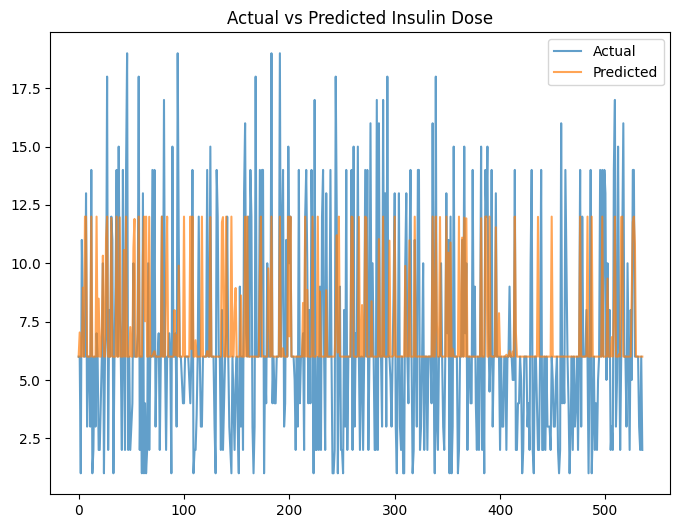

In [3]:
!pip uninstall tensorflow tensorboard -y
!pip install tensorflow tensorboard
!pip install --upgrade pip setuptools wheel
!pip install stable-baselines3[extra] tensorboard
!pip install tensorflow==2.11.0
import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load dataset
df = pd.read_csv("/kaggle/input/pp-diabetes/pp_dataset.csv")

df.rename(columns={
    "Pre-breakfast blood glucose measurement": "pre_breakfast_glucose",
    "Regular_insulin_Pre-breakfast_blood_glucose": "regular_insulin_pre_breakfast",
    "NPH insulin dose": "NPH_insulin_dose",
    "Pre-supper blood glucose measurement": "pre_supper_glucose",
    "Regular insulin dose": "regular_insulin_dose"
}, inplace=True)

# Outlier Clipping
df = df[(df['pre_breakfast_glucose'] > 50) & (df['pre_breakfast_glucose'] < 300)]
df = df[(df['NPH_insulin_dose'] > 0) & (df['NPH_insulin_dose'] < 50)]

# Feature Engineering
df['glucose_diff'] = df['pre_breakfast_glucose'] - df['pre_supper_glucose']
df['insulin_diff'] = df['NPH_insulin_dose'].diff().fillna(0)
df['glucose_insulin_interaction'] = df['pre_breakfast_glucose'] * df['NPH_insulin_dose']
df['glucose_insulin_ratio'] = df['pre_breakfast_glucose'] / (df['NPH_insulin_dose'] + 1e-5)
df.dropna(inplace=True)

# Define Features and Target
features = ["pre_breakfast_glucose", "NPH_insulin_dose", "pre_supper_glucose", "glucose_diff", "glucose_insulin_ratio", "insulin_diff", "glucose_insulin_interaction"]
target = "regular_insulin_dose"
X = df[features]
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling Features and Target
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Custom Gym Environment
class InsulinEnv(gym.Env):
    def __init__(self, X, y):
        super(InsulinEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32)
    
    def reset(self, seed=None, options=None):
        self.index = 0
        return np.array(self.X[self.index]), {}

    def step(self, action):
        actual_dose = self.y[self.index]
        predicted_dose = np.clip(action[0], 0, 1)
        error = abs(actual_dose - predicted_dose)
        reward = np.exp(-6 * error) if error < 0.15 else -3 * (error ** 2)
        self.index += 1
        done = self.index >= len(self.X)
        next_state = np.array(self.X[self.index]) if not done else np.zeros(self.observation_space.shape, dtype=np.float32)
        return next_state, reward, done, False, {}

# Create Environment
X_train_np = np.array(X_train_scaled, dtype=np.float32)
y_train_np = np.array(y_train_scaled, dtype=np.float32)
env = DummyVecEnv([lambda: InsulinEnv(X_train_np, y_train_np)])

# Model Configuration
policy_kwargs = dict(net_arch=[1024, 512, 256])
action_noise = NormalActionNoise(mean=np.zeros(1), sigma=0.08 * np.ones(1))

model = TD3(
    "MlpPolicy", env, verbose=1, learning_rate=2.5e-4, gamma=0.98,
    batch_size=512, buffer_size=600000, policy_kwargs=policy_kwargs, action_noise=action_noise
)

# Training Loop
for i in range(20):
    model.learn(total_timesteps=250000)
    model.learning_rate *= 0.90  # Learning rate decay

# Model Evaluation
def evaluate_model(model, X_test, y_test):
    predictions = np.array([model.predict(X_test[i])[0] for i in range(len(X_test))])
    predictions = y_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, mae, r2, predictions

mse, mae, r2, predictions = evaluate_model(model, X_test_scaled, y_test_scaled)
print(f"Optimized Results:\nMSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# Plot Results
plt.figure(figsize=(8, 6))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title("Actual vs Predicted Insulin Dose")
plt.legend()
plt.show()


***1st model**

In [1]:
# Install missing libraries
#!pip install stable-baselines3[extra] gymnasium numpy pandas scikit-learn --quiet

import numpy as np
import pandas as pd
import gymnasium as gym
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv("/kaggle/input/pp-diabetes/pp_dataset.csv")  # Adjust if needed

# Rename columns for consistency
df.rename(columns={
    "Pre-breakfast blood glucose measurement": "pre_breakfast_glucose",
    "Regular_insulin_Pre-breakfast_blood_glucose": "regular_insulin_pre_breakfast",
    "NPH insulin dose": "NPH_insulin_dose",
    "Pre-supper blood glucose measurement": "pre_supper_glucose",
    "Regular insulin dose": "regular_insulin_dose"
}, inplace=True)

# Feature Engineering
df['hour'] = pd.to_datetime(df.index, unit='D').hour
df['weekday'] = pd.to_datetime(df.index, unit='D').weekday
df['glucose_diff'] = df['pre_breakfast_glucose'] - df['pre_supper_glucose']
df['glucose_insulin_ratio'] = df['pre_breakfast_glucose'] / (df['NPH_insulin_dose'] + 1e-5)
df['insulin_diff'] = df['NPH_insulin_dose'].diff().fillna(0)

df.dropna(inplace=True)

# Feature Selection
features = [
    "pre_breakfast_glucose", "NPH_insulin_dose", "pre_supper_glucose", "hour", "weekday",
    "glucose_diff", "glucose_insulin_ratio", "insulin_diff"
]
target = "regular_insulin_dose"

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Custom Gym Environment
class InsulinEnv(gym.Env):
    def __init__(self, X, y):
        super(InsulinEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.index = 0
        return np.array(self.X[self.index]), {}

    def step(self, action):
        actual_dose = self.y[self.index]
        predicted_dose = np.clip(action[0], 0, 1)

        # Enhanced Reward Function
        error = abs(actual_dose - predicted_dose)
        reward = 1 - error if error < 0.5 else -error**2

        self.index += 1
        done = self.index >= len(self.X)
        next_state = np.array(self.X[self.index]) if not done else np.zeros(self.observation_space.shape, dtype=np.float32)

        return next_state, reward, done, False, {}

# Convert dataset to NumPy for Gym Environment
X_train_np = np.array(X_train_scaled, dtype=np.float32)
y_train_np = np.array(y_train_scaled, dtype=np.float32)

# Create environment
env = DummyVecEnv([lambda: InsulinEnv(X_train_np, y_train_np)])

# Train TD3 Model
model = TD3(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    gamma=0.99,
    batch_size=256,
    buffer_size=500000,
    policy_kwargs=dict(net_arch=[1024, 512, 256])
)

model.learn(total_timesteps=2000000)  # Increased training

# Save the trained model
model.save("/kaggle/working/td3_insulin_model")

# Load the model for evaluation
model = TD3.load("/kaggle/working/td3_insulin_model")

# Evaluation Function
def evaluate_model(model, X_test, y_test):
    X_test_np = np.array(X_test, dtype=np.float32)
    y_test_np = np.array(y_test, dtype=np.float32)
    predictions = []
    for i in range(len(X_test_np)):
        action, _ = model.predict(X_test_np[i].reshape(1, -1))
        predictions.append(np.clip(action[0], 0, 1))
    predictions = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    mse = mean_squared_error(y_test_np, predictions)
    mae = mean_absolute_error(y_test_np, predictions)
    r2 = r2_score(y_test_np, predictions)
    return mse, mae, r2, predictions

# Evaluate Model
mse, mae, r2, predictions = evaluate_model(model, X_test_scaled, y_test)
print(f"MSE: {mse}, MAE: {mae}, R2: {r2}")


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is d

Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 212      |
|    time_elapsed    | 44       |
|    total_timesteps | 9496     |
| train/             |          |
|    actor_loss      | 7.62     |
|    critic_loss     | 9.94     |
|    learning_rate   | 0.0003   |
|    n_updates       | 7122     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 187      |
|    time_elapsed    | 101      |
|    total_timesteps | 18992    |
| train/             |          |
|    actor_loss      | 19       |
|    critic_loss     | 11.3     |
|    learning_rate   | 0.0003   |
|    n_updates       | 16618    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 180      |
|    time_elapsed    | 158    

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:437: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_locati

MSE: 17.100685119628906, MAE: 3.25989031791687, R2: 0.11033061416117396


**2nd model**

In [2]:
# Install missing libraries
#!pip install stable-baselines3[extra] gymnasium numpy pandas scikit-learn --quiet

import numpy as np
import pandas as pd
import gymnasium as gym
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv("/kaggle/input/pp-diabetes/pp_dataset.csv")  # Adjust if needed

# Rename columns for consistency
df.rename(columns={
    "Pre-breakfast blood glucose measurement": "pre_breakfast_glucose",
    "Regular_insulin_Pre-breakfast_blood_glucose": "regular_insulin_pre_breakfast",
    "NPH insulin dose": "NPH_insulin_dose",
    "Pre-supper blood glucose measurement": "pre_supper_glucose",
    "Regular insulin dose": "regular_insulin_dose"
}, inplace=True)

# Feature Engineering
df['hour'] = pd.to_datetime(df.index, unit='D').hour
df['weekday'] = pd.to_datetime(df.index, unit='D').weekday
df['glucose_diff'] = df['pre_breakfast_glucose'] - df['pre_supper_glucose']
df['glucose_insulin_ratio'] = df['pre_breakfast_glucose'] / (df['NPH_insulin_dose'] + 1e-5)
df['insulin_diff'] = df['NPH_insulin_dose'].diff().fillna(0)

df.dropna(inplace=True)

# Feature Selection
features = [
    "pre_breakfast_glucose", "NPH_insulin_dose", "pre_supper_glucose", "hour", "weekday",
    "glucose_diff", "glucose_insulin_ratio", "insulin_diff"
]
target = "regular_insulin_dose"

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Custom Gym Environment
class InsulinEnv(gym.Env):
    def __init__(self, X, y):
        super(InsulinEnv, self).__init__()
        self.X = X
        self.y = y
        self.index = 0
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.index = 0
        return np.array(self.X[self.index]), {}

    def step(self, action):
        actual_dose = self.y[self.index]
        predicted_dose = np.clip(action[0], 0, 1)

        # Enhanced Reward Function
        error = abs(actual_dose - predicted_dose)
        reward = 1 - error if error < 0.5 else -error**2

        self.index += 1
        done = self.index >= len(self.X)
        next_state = np.array(self.X[self.index]) if not done else np.zeros(self.observation_space.shape, dtype=np.float32)

        return next_state, reward, done, False, {}

# Convert dataset to NumPy for Gym Environment
X_train_np = np.array(X_train_scaled, dtype=np.float32)
y_train_np = np.array(y_train_scaled, dtype=np.float32)

# Create environment
env = DummyVecEnv([lambda: InsulinEnv(X_train_np, y_train_np)])

# Train TD3 Model
model = TD3(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    gamma=0.99,
    batch_size=256,
    buffer_size=500000,
    policy_kwargs=dict(net_arch=[1024, 512, 256])
    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a futur

Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 217      |
|    time_elapsed    | 43       |
|    total_timesteps | 9496     |
| train/             |          |
|    actor_loss      | 8.66     |
|    critic_loss     | 12.9     |
|    learning_rate   | 0.0003   |
|    n_updates       | 7122     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 189      |
|    time_elapsed    | 100      |
|    total_timesteps | 18992    |
| train/             |          |
|    actor_loss      | 22.1     |
|    critic_loss     | 14.3     |
|    learning_rate   | 0.0003   |
|    n_updates       | 16618    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 182      |
|    time_elapsed    | 156    

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:437: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_locati

MSE: 16.514461517333984, MAE: 3.2372562885284424, R2: 0.14082915109694571
